## Imports

In [182]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

import tmdbsimple as tmdb
import os, time,json
from tqdm.notebook import tqdm_notebook

## Data 

In [ ]:
# loading previous MovieTime Analysis notebook dataframes
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
akas = pd.read_csv("Data/title_akas.csv.gz", low_memory = False)
ratings = pd.read_csv("Data/title_ratings.csv.gz", low_memory = False)

### Basics

In [3]:
# checking for missing values
basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82150 entries, 0 to 82149
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          82150 non-null  object 
 1   titleType       82150 non-null  object 
 2   primaryTitle    82150 non-null  object 
 3   originalTitle   82150 non-null  object 
 4   isAdult         82150 non-null  int64  
 5   startYear       82150 non-null  int64  
 6   endYear         0 non-null      float64
 7   runtimeMinutes  82150 non-null  int64  
 8   genres          82150 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 5.6+ MB


In [4]:
# dropping endYear column, all null
basics = basics.drop(columns = ["endYear"])

### Akas

In [5]:
# checking for missing values
akas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342956 entries, 0 to 1342955
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   titleId          1342956 non-null  object 
 1   ordering         1342956 non-null  int64  
 2   title            1342956 non-null  object 
 3   region           1342956 non-null  object 
 4   language         3681 non-null     object 
 5   types            963321 non-null   object 
 6   attributes       44751 non-null    object 
 7   isOriginalTitle  1341581 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 82.0+ MB


In [6]:
# replacing null values as unknown
akas["language"].fillna("Unknown", inplace = True)
akas["types"].fillna("Unknown", inplace = True)
akas["attributes"].fillna("Unknown", inplace = True)
akas["isOriginalTitle"].fillna("Unknown", inplace = True)

### Ratings

In [7]:
# check for missing values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263582 entries, 0 to 1263581
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1263582 non-null  object 
 1   averageRating  1263582 non-null  float64
 2   numVotes       1263582 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 28.9+ MB


## TMDB API Processing

In [8]:
# tmdbsimple
!pip install tmdbsimple  --no-warn-script-location

Defaulting to user installation because normal site-packages is not writeable


In [9]:
# API credentials
with open('/Users/joshu/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
login.keys()

import tmdbsimple as tmdb
tmdb.API_KEY =  login['api-key']

In [10]:
# instantiating API key
tmdb.API_KEY =  login['api-key']

In [11]:
# designating folder 'Data' to save my API calls
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz']

In [12]:
# my client's desired years
YEARS_TO_GET = [2000, 2001]

In [13]:
# helper functions prior to running loop
def read_and_fix_json(JSON_FILE):
    """Attempts to read in json file of records and fixes the final character
    to end with a ] if it errors.
    
    Args:
        JSON_FILE (str): filepath of JSON file
        
    Returns:
        DataFrame: the corrected data from the bad json file
    """
    try: 
        previous_df =  pd.read_json(JSON_FILE)
    
    ## if read_json throws an error
    except:
        
        ## manually open the json file
        with open(JSON_FILE,'r+') as f:
            ## Read in the file as a STRING
            bad_json = f.read()
            
            ## if the final character doesn't match first, select the right bracket
            first_char = bad_json[0]
            final_brackets = {'[':']', 
                           "{":"}"}
            ## Select expected final brakcet
            final_char = final_brackets[first_char]
            
            ## if the last character in file doen't match the first char, add it
            if bad_json[-1] != final_char:
                good_json = bad_json[:-1]
                good_json+=final_char
            else:
                raise Exception('ERROR is not due to mismatched final bracket.')
            
            ## Rewind to start of file and write new good_json to disk
            f.seek(0)
            f.write(good_json)
           
        ## Load the json file again now that its fixed
        previous_df =  pd.read_json(JSON_FILE)
        
    return previous_df

In [14]:
def movie_rating(movie_id):
    
    # getting the movie object for the current id
    movie = tmdb.Movies(movie_id)

    # save the .info .releases dictionaries
    movie_info = movie.info()
    
    releases = movie.releases()
    # looping through countries in releases
    for c in releases['countries']:
        if c['iso_3166_1' ] =='US':
           movie_info['certification'] = c['certification']
    return movie_info

In [15]:
# preparing the inner loop  (https://www.geeksforgeeks.org/append-to-json-file-using-python/)
def write_json(new_data, filename):   
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [16]:
# outer loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    file_exists = os.path.isfile(JSON_FILE)
    
    if file_exists == False:
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
            
    df = basics.loc[basics['startYear']==YEAR].copy()
    movie_ids = df['tconst'].copy()
    previous_df = read_and_fix_json(JSON_FILE)
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]        

    # inner loop
    for movie_id in tqdm_notebook(movie_ids_to_get, 
                                  desc=f'Movies from {YEAR}', 
                                  position=1, leave=True):
        try:
            temp = movie_rating(movie_id)
            write_json(temp, JSON_FILE)
            time.sleep(0.02)
            
        except Exception as e:
            continue
            
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)


YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/1407 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/1529 [00:00<?, ?it/s]

## Exploratory Data Analysis

In [33]:
# df by desired year
df2000 = pd.read_csv("./Data/final_tmdb_data_2000.csv.gz")
df2001 = pd.read_csv("./Data/final_tmdb_data_2001.csv.gz")

In [34]:
combined_dfs = [df2000, df2001]
df = pd.concat(combined_dfs)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2491 entries, 0 to 1287
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2491 non-null   object 
 1   adult                  2489 non-null   float64
 2   backdrop_path          1290 non-null   object 
 3   belongs_to_collection  197 non-null    object 
 4   budget                 2489 non-null   float64
 5   genres                 2489 non-null   object 
 6   homepage               174 non-null    object 
 7   id                     2489 non-null   float64
 8   original_language      2489 non-null   object 
 9   original_title         2489 non-null   object 
 10  overview               2437 non-null   object 
 11  popularity             2489 non-null   float64
 12  poster_path            2195 non-null   object 
 13  production_companies   2489 non-null   object 
 14  production_countries   2489 non-null   object 
 15  rele

In [35]:
# prep NaN to 0 for financial information (values > 0 for budget OR revenue)
df['revenue'].fillna(value = 0, inplace = True)
df['budget'].fillna(value = 0, inplace = True)

In [36]:
# financial information (values > 0 for budget OR revenue)
revenue_filter = df["revenue"] > 0
budget_filter = df["budget"] > 0

# combining financial info for revenue OR budget
fin_info = df.loc[(df['revenue'] > 0) | (df['budget'] > 0)]

In [38]:
# explore filtered financial info
fin_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 1 to 1268
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                620 non-null    object 
 1   adult                  620 non-null    float64
 2   backdrop_path          519 non-null    object 
 3   belongs_to_collection  102 non-null    object 
 4   budget                 620 non-null    float64
 5   genres                 620 non-null    object 
 6   homepage               80 non-null     object 
 7   id                     620 non-null    float64
 8   original_language      620 non-null    object 
 9   original_title         620 non-null    object 
 10  overview               617 non-null    object 
 11  popularity             620 non-null    float64
 12  poster_path            599 non-null    object 
 13  production_companies   620 non-null    object 
 14  production_countries   620 non-null    object 
 15  relea

In [181]:
# groupby cert and rev
rev_avg = fin_info.groupby('certification')['revenue'].agg(mean_revenue = ("mean"))

#set new aggregate mean onto rev_avg
rev_avg = rev_avg.reset_index()
rev_avg.head()

,certification,mean_revenue
0,G,1.237085e+08
1,NR,8.887619e+06
2,PG,1.123378e+08
3,PG-13,9.970084e+07
4,R,3.334614e+07


In [174]:
# def function for millions
def hundred_m(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    return f"${x/1000000:,.0f}M"

# function test
hundred_m(120000000,0)

'$120M'

In [176]:
# creating a formatter for improved viz
price_fmt_100m = FuncFormatter(hundred_m)

### Revenue Average by Certification Category

Text(0.5, 1.0, 'Revenue Average by Certification Category')

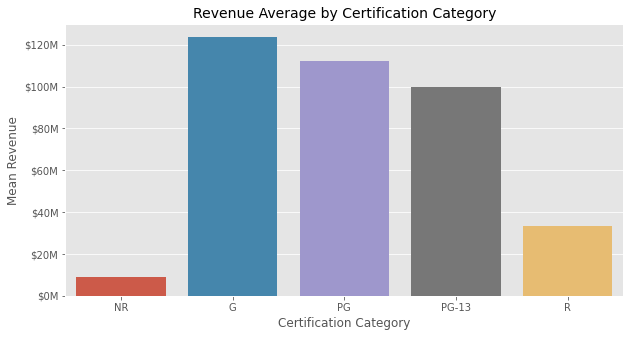

In [191]:
# average revenue bar plot

# set the style
plt.style.use('ggplot')

# set the size
fig, ax = plt.subplots(figsize=(10,5))
ax.yaxis.set_major_formatter(price_fmt_100m)


# plot bars
g = sns.barplot(x='certification', 
                y='mean_revenue', 
                order=["NR","G","PG","PG-13","R"],
                data = rev_avg) 

# labels and title
plt.ylabel("Mean Revenue", size=12)
plt.xlabel("Certification Category", size=12)
plt.title("Revenue Average by Certification Category", size=14)

### Revenue Budget by Certification Category

In [186]:
# grouping certs by budget mean
budget_avg = fin_info.groupby('certification')['budget'].agg(mean_budget = ("mean"))
budget_avg

#set new aggregate mean onto rev_avg
budget_avg = budget_avg.reset_index()
budget_avg.head()

,certification,mean_budget
0,G,4.085714e+07
1,NR,6.300006e+06
2,PG,4.497857e+07
3,PG-13,4.348391e+07
4,R,2.013149e+07


Text(0.5, 1.0, 'Budget Average by Certification Category')

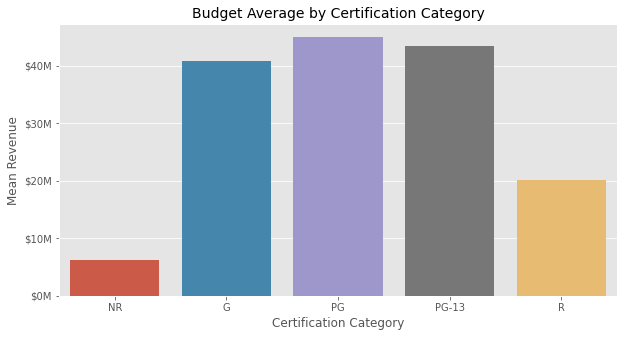

In [192]:
# budget average bar plot

# set the style
plt.style.use('ggplot')

# set the size
fig, ax = plt.subplots(figsize=(10,5))
ax.yaxis.set_major_formatter(price_fmt_100m)


# plot bars
g = sns.barplot(x='certification', 
                y='mean_budget', 
                order=["NR","G","PG","PG-13","R"],
                data = budget_avg) 

# labels and title
plt.ylabel("Mean Revenue", size=12)
plt.xlabel("Certification Category", size=12)
plt.title("Budget Average by Certification Category", size=14)